In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
from pathlib import Path
from scipy.io import loadmat
import pickle
from copy import deepcopy

In [2]:
from bayesee.perception import *
from bayesee.validation import *
from bayesee.visualization import *
from bayesee.generation import *
from bayesee.evaluation import *
from bayesee.iteration import *
from bayesee.partition import *

In [3]:
%load_ext autoreload
%autoreload 2
plt.style.use('bayesee.academic')

In [4]:
repo_path = Path.cwd().parents[0]
print(repo_path)

c:\Users\aqfra\Documents\GitRepo\bayesee


In [5]:
subject = "AZ"
file_name = repo_path / f"data/discrimination/location/data_{subject}.pickle"

with open(file_name, "rb") as f:
    stimulus, response = pickle.load(f)

metadata = stimulus["metadata"]
print(metadata.keys())

dict_keys(['background_std', 'background_contrast', 'background_mean', 'max_clip_ratio', 'cue_time', 'camera_bit_depth', 'monitor_bit_depth', 'monitor_gamma', 'monitor_size', 'stimulus_ppd', 'cue_off_time', 'stimulus_time', 'target', 'experiment_title', 'stimulus_size'])


In [6]:
stimulus_iso = deepcopy(stimulus)
response_iso = deepcopy(response)

stimulus_iso["df"].rename(columns={"location": "presence"}, inplace=True)
response_iso["df"].rename(
    columns={"response_location": "response_presence"}, inplace=True
)

stimulus_iso["df"]["presence"] -= 1
response_iso["df"]["response_presence"] -= 1

In [7]:
array_dprime, array_criterion = compute_dprime_criterion_w_discrete_response(
    stimulus_iso, response_iso
)

array_PC_max = compute_PC_max_w_dprime(array_dprime)

[Text(0.5, 0, 'Displacement amplitude (arc min)'), Text(0, 0.5, 'Value')]

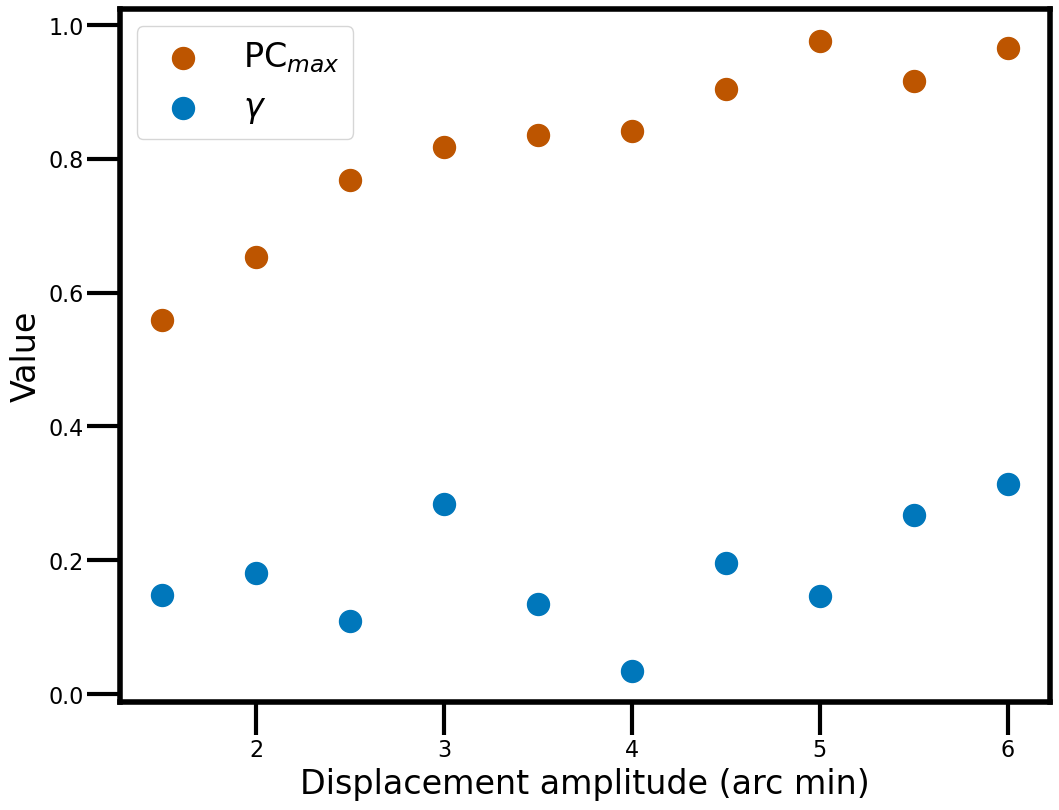

In [8]:
fig, ax = plt.subplots()
amplitude_unique, index_unique = np.unique(
    stimulus["df"]["amplitude"], return_index=True
)

ax.scatter(
    amplitude_unique,
    array_PC_max[index_unique],
    s=250,
    label="PC$_{max}$",
)
ax.scatter(
    amplitude_unique,
    array_criterion[index_unique],
    s=250,
    label="$\gamma$",
)

ax.legend(loc="best")

ax.set(xlabel="Displacement amplitude (arc min)", ylabel="Value")

In [9]:
x0 = [3.5, 0]

results = minimize(
    negative_loglikelihood_w_parameter,
    x0,
    args=(stimulus, response, unit_likelihood_gaussian),
)

results

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 502.57311276418517
        x: [ 3.591e+00  5.960e-01]
      nit: 8
      jac: [ 1.526e-04 -3.815e-06]
 hess_inv: [[ 4.720e-03  1.499e-02]
            [ 1.499e-02  4.762e-02]]
     nfev: 140
     njev: 43

In [10]:
sigma, gamma = results.x

(0.0, 6.930000000000001)

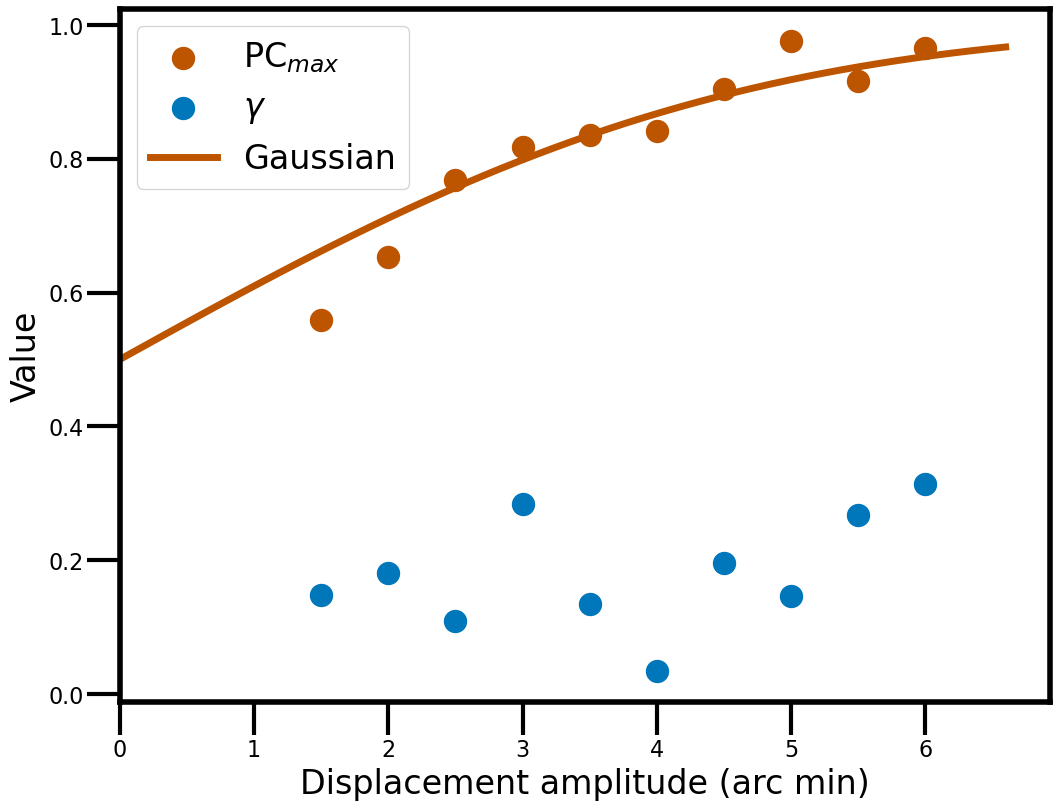

In [11]:
fig, ax = plt.subplots()
amplitude_unique = np.unique(stimulus["df"]["amplitude"])

ax.scatter(
    amplitude_unique,
    array_PC_max[index_unique],
    s=250,
    label="PC$_{max}$",
)
ax.scatter(
    amplitude_unique,
    array_criterion[index_unique],
    s=250,
    label="$\gamma$",
)

amplitude_full = np.linspace(0, amplitude_unique.max() * 1.1, 50)

ax.plot(
    amplitude_full,
    norm.cdf(amplitude_full / sigma),
    label="Gaussian",
)

ax.legend(loc="best")
ax.set(
    xlabel="Displacement amplitude (arc min)",
    ylabel="Value",
)
ax.set_xlim(left=0)